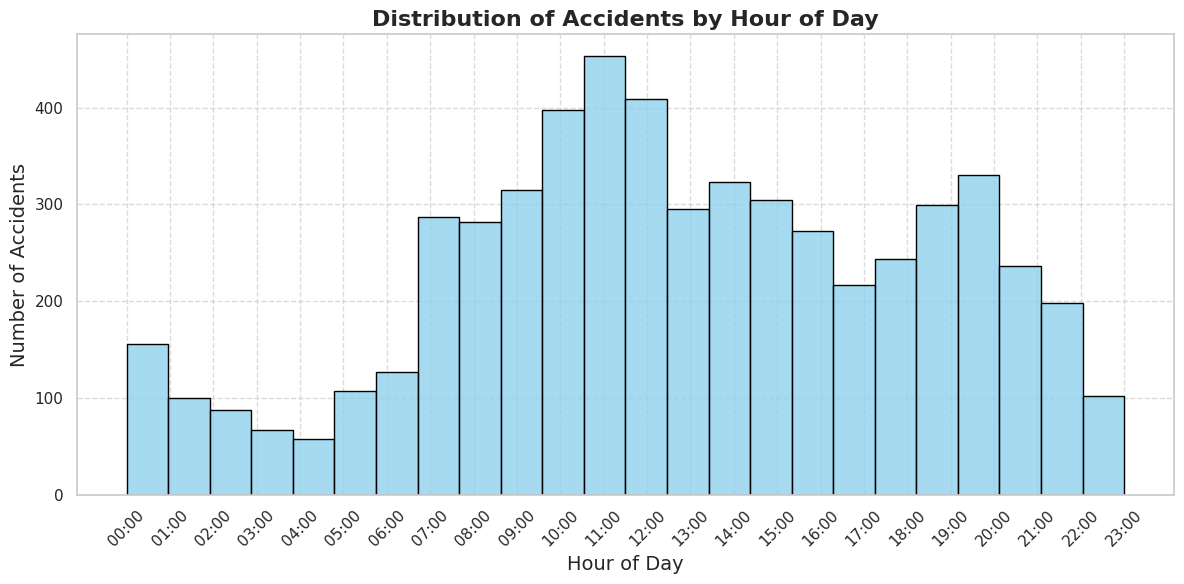

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           2       0.61      0.88      0.72       996
           3       0.54      0.21      0.30       703
           4       0.00      0.00      0.00         1

    accuracy                           0.60      1700
   macro avg       0.38      0.36      0.34      1700
weighted avg       0.58      0.60      0.55      1700



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


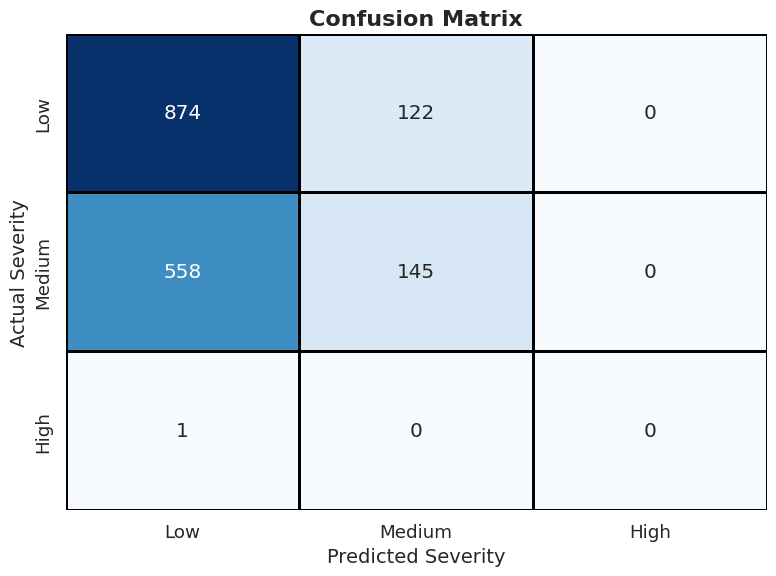

Accuracy: 0.60


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from folium.plugins import HeatMap


us_accident = pd.read_csv('US_Accidents_March23.csv')


us_accident.dropna(subset=['Start_Lat', 'Start_Lng', 'Severity'], inplace=True)

map_center = [us_accident['Start_Lat'].mean(), us_accident['Start_Lng'].mean()]
m = folium.Map(location=map_center, zoom_start=12)
heat_data = [[row['Start_Lat'], row['Start_Lng']] for index, row in us_accident.iterrows()]
HeatMap(heat_data).add_to(m)
m.save('heatmap.html')


us_accident['Start_Time'] = pd.to_datetime(us_accident['Start_Time'])
us_accident['Hour'] = us_accident['Start_Time'].dt.hour


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.histplot(us_accident['Hour'], bins=24, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Accidents by Hour of Day', fontsize=16, weight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(range(0, 24), labels=[f'{i:02}:00' for i in range(24)], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


features = ['Hour', 'Traffic_Signal', 'Roundabout', 'Traffic_Calming', 'Sunrise_Sunset']
X = pd.get_dummies(us_accident[features], drop_first=True)
y = us_accident['Severity']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)


print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'], linewidths=1, linecolor='black')
plt.title('Confusion Matrix', fontsize=16, weight='bold')
plt.xlabel('Predicted Severity', fontsize=14)
plt.ylabel('Actual Severity', fontsize=14)
plt.tight_layout()
plt.show()


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
